In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                       low_memory=False, 
                       nrows=10**6)
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')

# step1 熟悉数据
在建立模型之前，最重要的是去熟悉数据，熟悉数据有几个目的：
1. 了解数据的含义，以根据经验初步筛选你模型中需要用到的数据列和不需要的数据列。
    
    本题的数据含义见我的熟悉数据notebook：https://www.kaggle.com/zcatherine/riiid
   
   
2. 思考数据间的关系，以便选取合适的模型和参数。
   
   比如：本题是一个二分类的概率预测，我用MLP写了一个简单的模型，那么这种问题的优化器通常会选择RMSProp，激活函数选择sigmoid的组合比较合适；有的特征单独看和结果没什么关系，但是两个或多个特征组合在一起会对结果产生较大的影响(e.g. XOR)，那么就要在模型中加入非线性结构。
   
   
3. 对数据进行处理，包括填补nan和把一些列处理成你想要的特征。
   
   关于nan的是否填补，填补为哪些值（平均数？众数？0？INF？pre预测结果？）也是一个需要思考的问题。就好像本题的训练集中，上一个题目是否有解释这一列有true、false、nan三种值，我一开始就不确定要不要把nan填补成false，但是后来考虑到这些nan代表着第一个题目，或许也有它的意义，然后写出本文中的feature3之后发现它和false关于作答是否正确的平均值和方差还是有区别，所以最终还是没有去填补它。

# step2 选择模型
熟悉好数据之后就要做特征选择（处理）和选择模型了，本题目前最好用的模型应当是讨论区提到的SANT+：http://arxiv.org/abs/2010.12042

但是不走科研新成果捷径的话（毕竟新手有时候没办法看懂新论文后就立马能写出来那个代码），新手去挑选目前已学习到的各种模型（lstm\RNN\RandomForest\NLP\MLP...），应当以什么作为挑选准则呢？

（个人认为特征处理和模型选择是分不开的，所以我把它们放到一起考虑）

我也在这样的一个摸索阶段。

有人说，这些模型都差不多，最重要的还是数据清洗、特征选择和特征处理。

但是我认为，模型的内部结构决定了能够造出来的模型的几何形状的空间，起码这一点还是要明确（也就是说，比如你去拿一个分类模型去做一个线性的预测，一个几何空间是离散值，另一个是线，根本就对不上；或者就好比一个最多产生二次函数的模型拿去预测三维空间的值，就不能适用。非数学专业，描述不太准确，全靠感觉，实在抱歉，欢迎指正）。

我的思考过程：

这个题目学生做题正确率确实是个监督学习下的二分类的题目，但是学生做题水平会随着时间提高，也要考虑时间序列的因素（LSTM,RNN啥的），我个人才疏学浅，目前也只是学了一些模型的原理，还没怎么写过代码，所以就拿那个可以用非线性面分割空间，模型简单又有现成的接口可以直接用的MLP开刀吧。

# step3 特征处理
对于lecture文件，我认为有意义的东西包括lecture对应的tag跟part，question也是一样。tag的含义是知识点，那么一定是预测学生是否能做对题目（基本等同于是否掌握知识点）的最重要的信息，我需要要把处理的重心放在这里，但它可能也是最难的部分？tag跟part似乎要结合在一起更有意义，但是应该怎么实现呢？

我去翻找了其他人对tag做的工作，发现了一个想法相投的伙计https://www.kaggle.com/yanamal/questions-tags-and-lectures-riiid-metadata-eda
还发现了一个做了好看的聚类分析的大兄弟：https://www.kaggle.com/spacelx/2020-r3id-clustering-question-tags

Yana Malysheva的工作非常有趣，他得出了一些有指导意义的结论，说明tags在不同part的划分具有意义，包括：
* part5和part6会问一些相似问题（具有相同tag）；
* part1-4包含相同的tag（和听力理解有关）；
* 1-4与7只考察综合知识（多tag），5只考察某个知识点（单tag）；
* tag162使得part6区分于part5；
* part3-4的每个问题都会包含[74, 82, 161, 106, 136, 157, 113]其中的一个

此外，他还探索了tag的含义，比如那些没出现在讲座里的标签，可能是虚的内容（比如听力能力），并提出了关于part3-4中tag跟难度的关系猜想。

-

我想一定有人可以通过这些信息来将tag和part做出合适的好的处理，但是我最初的模型恐怕不适合体量太大，就先将tag和part分开做一下处理好了，另外，我认为一个知识点可以迁移运用，其实也不会那么拘泥于涉及的part。相同tag对不同part，区分更多的可能是一些解题技巧。

最终，我想对L&Q的tag做的处理是，计算出一个用户是否学习过question涉及的tag，对于包含多个tag的question，计算学过的tag所占的比率（这个特征确实不太好，我还在思考要怎么去做改进，比如是否要去掉那些没有单独出现或没有在lecture出现的tag，或者再进一步，把那些看过解释的问题的tag也加入进来）

我的第一个处理步骤是，提取用户从lecture中学到的tags：

In [ ]:
# 准备用户看过的lectures具有的tag的表user_lec
def add_user_lec(data,lectures):
    # 从数据中分出lecture行，选择需要的信息并对id重命名以便merge
    data = data[data['content_type_id'] == 1]
    data = data[['user_id','content_id']].copy()
    data.rename(columns = {"content_id": "lecture_id"}, inplace = True)

    data = data.merge(lectures,'left')
    
    # 构造空的表来存储用户学的tags
    col = ['user_id','lec_tag']
    user_lec = pd.DataFrame(columns = col)
    
    # 将不同用户看过的tag以list形式存起来
    user_id = data['user_id'].unique()
    idx = 0
    for uid in user_id:
        tmptdf = data[data[col[0]] == uid]
        tlist = tmptdf['tag'].tolist()
        user_lec.loc[idx] = {col[0]:uid, col[1]:tlist}
        idx += 1
    
    return user_lec

user_lec = add_user_lec(train_df,lectures)
user_lec.head()

接下来是对question表的处理：

In [ ]:
# 简化问题表（tags列含有nan）
tqdf = questions[['question_id','part','tags']].copy()
tqdf.fillna(0,inplace = True)
# 将tags由string和int（填补的0）类型变为int类型的list
tqdf['tags'] = tqdf['tags'].apply(lambda tgs:  [int(x) for x in str(tgs).split()])
tqdf.head()

接下来是根据我对数据的理解，提取一些有用的特征和分布，我认为影响一个*学生*对于一个*问题*是否能答对，除了看他是不是学过，还要看学生水平和问题难度。

因此，我用一个学生的答题正确率和标准差来表征学生水平，问题难度同理。

此外，学生是否看过上一个问题的解释也对学生是否能做对当前题目会有影响（我想到了高中做阅读的场景，做了一个题，学了几个单词或者学了个做题方法，下一个题用上了。或者同一篇阅读做一个题目就看一个答案可能有点过分）

In [ ]:
import string

# 选取问题集，删去多余列,填补缺失答案（应当没有缺失，但是我又被这个scoring error给人整傻了还是加上吧）
tdf = train_df[train_df['content_type_id'] == 0].copy()
tdf = tdf.drop(['content_type_id','row_id'],1)
tdf['answered_correctly'] = tdf['answered_correctly'].apply(lambda x: 0 if str(x) == 'nan' else x)
    
# 构造新的features
features = tdf[['user_id','content_id','answered_correctly','prior_question_had_explanation']].copy()
features.rename(columns = {"content_id": "question_id"}, inplace=True)

# 不同用户的做题正确率（表征用户水平）
feature1 = features.groupby('user_id').agg({'answered_correctly': [
                                                'mean',
                                                'std'
                                            ]}).reset_index().copy()
feature1.columns = ['user_id','u_min','u_std']

# 不同问题的做题正确率（表征题目难度）
feature2 = features.groupby('question_id').agg({'answered_correctly': [
                                                'mean',
                                                'std'
                                                ]}).reset_index().copy()
feature2.columns = ['question_id','q_min','q_std']

# 是否看过上个题目答案解释和做题正确率的关系分布
features['prior_question_had_explanation'] = features['prior_question_had_explanation'].astype(str)
feature3 = features.groupby('prior_question_had_explanation').agg({'answered_correctly': [
                                                                    'mean',
                                                                    'std'
                                                                    ]}).reset_index().copy()
feature3.columns = ['prior_question_had_explanation','e_min','e_std']

# 看一下nan和false的区别
feature3.head()

上面准备好了处理过的lecture跟question表还有自己选取的几个特征，接下来就要拼接它们来构造训练集了。

SANT+对于SANT的改进就是使用了ET和LT，这两个时间在SANT+的论文中有图片可以解释，这里的ET数据集本身就已经给出，实际上我是想处理出来一个LT跟一个用户加入平台的总时间的，但是这有点复杂，所以我就还没有实现，只先简单的用了一下给出的时间戳：

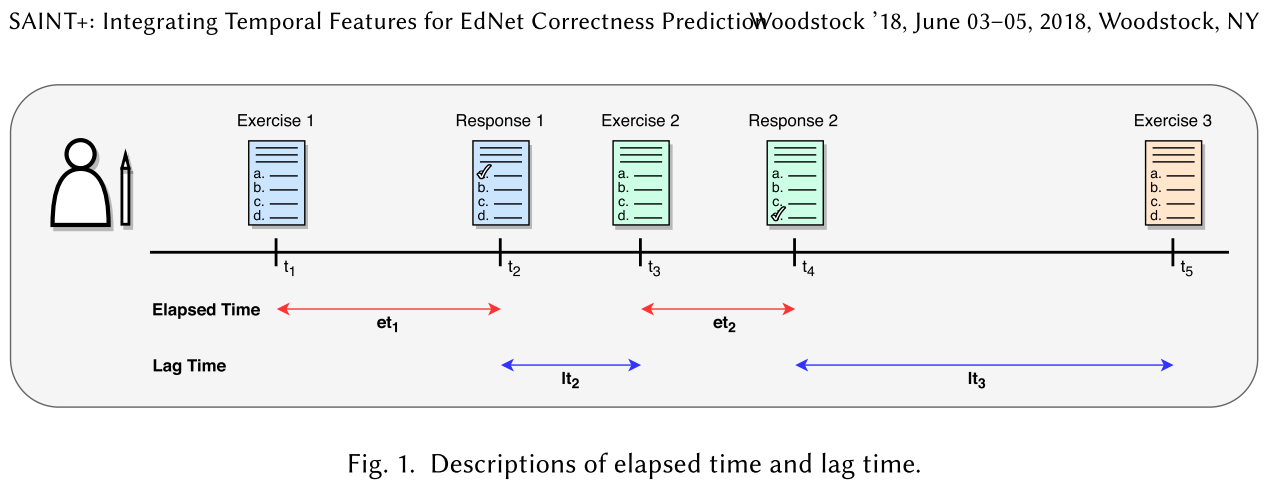

In [ ]:
# 这处耗费CPU
# 找a和b的交集（不知道用set快还是这个快，但是肯定这个稳一点）
def csnm(a,b):
    ans = 0
    for i in a:
        if i in b:
            ans += 1
    return ans

# 将标签转化为学习过的比例（考虑改进，加入遇到过且看过解释的标签）
def trans_tags(data):
    # 时间戳也加了进来，如果距离上一个题目间隔时间不过长（代表着不遗忘），越往后可能学的越多做的越好
    cols = ['timestamp','user_id','content_id','task_container_id','prior_question_elapsed_time','prior_question_had_explanation']
    data = data[cols].copy()
    
    # 防止explanation里的nan被fill
    data['prior_question_had_explanation'] = data['prior_question_had_explanation'].astype(str)
    data.fillna(0, inplace = True)
    
    # 方便merge
    data.rename(columns = {"content_id": "question_id"}, inplace=True)
    
    # 合并fetures，选择left，保留data所有的内容
    data = pd.merge(data,feature1,'left',sort = False)
    data = pd.merge(data,feature2,'left',sort = False)
    data = pd.merge(data,feature3,'left',sort = False)
    
    # 表征都用0.5填补nan
    data.fillna(0.5, inplace = True)
    
    # 合并question和lecture
    data = pd.merge(data,tqdf,'left',sort = False)
    data = pd.merge(data,user_lec,'left',sort = False)
    
    # 将问题的tag的nan用[-1]填补，讲座的tag用[0]填补以区分它们
    data['tags'] = data['tags'].apply(lambda x:  [-1] if str(x) == 'nan' else x)
    data['lec_tag'] = data['lec_tag'].apply(lambda x: [0] if str(x) == 'nan' else x)
    
    data.fillna(0, inplace = True)
    
    # 计算学习过的比率，去除无用列
    tlst = data.apply(lambda x: csnm(x['tags'],x['lec_tag'])/(len(x['tags'])+1e-3), axis = 1)
    data = data.drop(['tags','lec_tag'],1)
    data["learned_ratio"] = tlst
    
    # 这里是因为发现nan跟true的结果接近，最后觉得还是保留做一下尝试
    data['prior_question_had_explanation'] = data['prior_question_had_explanation'].apply(lambda x: 'True' if x == 'nan' or x == '<NA>' else x)
    
    return data

tdf = trans_tags(tdf)
tdf.head()

In [ ]:
tdf.describe()

# step4 数据scale
在选择好特征之后，还有一些有用的列值没有经过处理，他们的数值量级比处理过的量级大得多，这会影响调参效率和结果，所以还要对这些列值做一个归一化、标准化之类的处理，另外part1-7也可以做一个onehot编码，考虑到后续test数据的不完整性，这里对part编码后保存encoder直接对后续test数据进行处理：

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder
import tensorflow as tf

# 数据scale
def enc_scl(data):
    # 类别编码
    le = LabelEncoder()
    le = le.fit(['True', 'False'])
    data['prior_question_had_explanation'] = le.transform(data['prior_question_had_explanation'])
    
    # 使用MinMaxScaler归入区间[0,1]
    sclcol = ['timestamp','task_container_id', 'prior_question_elapsed_time']
    min_max_scaler = MinMaxScaler()
    data[sclcol] = min_max_scaler.fit_transform(data[sclcol])
                                                   
    return data

tdf = enc_scl(tdf)

# onehot编码
enc = OneHotEncoder()
# 因为要输入二维向量所以要进行reshape
tpart = tdf['part'].values.reshape(-1, 1)
# fit并保存到one_hot_enc
one_hot_enc = enc.fit(tpart)
# 转化后要进行toarray来获取trans之后的二维数组
tpart = one_hot_enc.transform(tpart).toarray()
# 构建新的dataframe保存结果
partcol = ['1','2','3','4','5','6','7']
tpart = pd.DataFrame(columns = partcol,data = tpart)
# 去掉part列，合并新的dataframe
tdf = tdf.drop('part',1)
tdf = tdf.join(tpart)

# 构造训练集
train_x = tdf.drop(['user_id','question_id'],1)
train_y = train_df['answered_correctly'].copy()
train_x.head()

# step5 构造模型
step2中说明过选择MLP模型的理由，这里就不再重复，如何使用keras写模型可以参考https://keras.io/guides/functional_api/

首先还是构造一个序列模型，叠层的时候考虑到层数多了容易收敛过快+过拟合，这里就只构造了一个两层模型，节点数的选择确实很困难，我尝试了多次调整，但是差别不大，就随便选了一个数（感觉输入shape的2倍好用的）。

至于激活函数的选择，一般情况下relu的表现都不错，二分类概率问题最后选用sigmoid，经过尝试发现这样确实是合适的组合。

后面模型metrics中的AUC函数是从CSDN上找的，大家可以通过他的用户名搜到来源。

模型的参数我进行了初始化，也是选取比较通用的he_normal, loss是二分类的交叉验证方法，优化器我试了一下自适应学习率的adadelta（ https://keras.io/zh/optimizers/#adadelta ），最终发现还是rmsprop效果好：

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, advanced_activations
from keras import backend as K
import keras

model = Sequential()
model.add(Dense(36, input_shape=(18,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# AUC函数来源：AI_盲（CSDN）
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N


# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

# AUC for a binary classifier
def auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)
'''
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=[auc])
'''
keras.initializers.he_normal(seed=None)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[auc])

# step6 模型训练
模型训练要考虑的参数：

batch_size：太大或者太小都会训练很慢，适中的batch_size可以提高训练速度（还记得mini-batch那一课么？），这里考虑到训练数据集有100w数据，就选择了4800（微调了一下）。

epochs：    作为一个训练轮次，当然可以自适应，但是我不希望太多以致太慢，也不希望太少看不出效果，影响我的效率，于是设置为30。

其他参数不做过多解释，但是在文档中都可以找到具体含义，新手就是要多学习文档。

In [ ]:
model.fit(train_x, train_y, batch_size=4800, epochs=30, verbose=1,validation_split=0.2,
          shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)

# step7 模型预测与结果提交
题外话：终于训练好一个模型之后就要开始预测和提交模型啦，这里的env卡了我好久，就是之前直接写在另一个notebook里的模型一直过不去卡了我30多version，直到我开始写这份notebook用阉割版模型一点一点加上来才拿到了分数，但是明明两个notebook没有什么区别，我的这个模型训练结果是0.5几，另一个一直scoring error的模型结果是0.7几，我还没找到差在哪了，还是挺懵的。还有就是这个模型有时候改一点点突然就跑得很慢，我也没弄明白到底是为什么。

------------ 另一个notebook用了.copy()之后也跑出分了[doge]，得分0.692，但我还是找不出两个notebook的差别在哪，哭泣 ------------
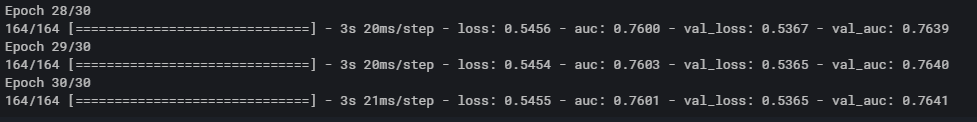


预测的时候也还是要处理test集，就像处理train集一样

In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

for (sample_test,sample_prediction_df) in iter_test:
    # 更新用户看过的lecture包含的tags
    user_lec = user_lec.append(add_user_lec(sample_test,lectures))
    # 去除重复（实际上应该合并相同id的tags列表，但是我还没有搞）
    user_lec = user_lec.drop_duplicates(['user_id'])
    
    # 选取问题集，进行数据预处理
    sample_test = sample_test[sample_test['content_type_id'] == 0].copy()
    test = trans_tags(sample_test)
    test = enc_scl(test)
    
    tpart = test['part'].values.reshape(-1, 1)
    tpart = one_hot_enc.transform(tpart).toarray()
    partcol = ['1','2','3','4','5','6','7']
    tpart = pd.DataFrame(columns = partcol,data = tpart)
    test = test.drop('part',1)
    test = test.join(tpart)
    
    test = test.drop(['user_id','question_id'],1)
    
    # 模型预测
    res = model.predict(test)
    
    # 构造submission
    sample_test['answered_correctly']=res
    env.predict(sample_test[['row_id','answered_correctly']])

最后，future works很多，也不止这个模型需要修改，我还有在考虑把tags处理一下之后也做一个onehot，目前也在学习transformer和sant还有sant+。最后还是想用利器sant+来实现的hhh，希望自己可以尽快学会！等我学会了再来给你们看成果~

如果本文有什么问题，欢迎大家来指点我！

---------------------- 致谢 --------------------------

感谢 Shuhao Cao，我使用了.copy() 之后发现不仅仅是没有warning了，代码跑起来也快了很多，非常舒适